In [88]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import DataFrame, Series
import warnings

import geopandas as gpd
import geoplot as gplt
from adjustText import adjust_text

from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('pdf', 'svg')
set_matplotlib_formats('retina', 'png')
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

import seaborn as sns
sns.set() # sets seaborn default "prettyness:
sns.set_style("white")
sns.set_context("notebook")

from pathlib import Path

/var/folders/33/sv_s_4ps2gjgpwdxjvz9jly00000gn/T/ipykernel_85713/4290429153.py:14: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('retina', 'png')


## Meta data

In [89]:
meta_data = pd.read_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM.xlsx')
meta_data.head()

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F


Assign 'U' as unknown sex:

In [90]:
meta_data.loc[meta_data.Sex.isnull(), 'Sex'] = 'U'

Set https proxy. Jupyter does not inherrit the one set set for other shells.

In [91]:
# only use this on the cluster:
#%env https_proxy=http://in:3128 

Automacially retrieve geolocations:

In [92]:
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="baboon_map")
geolocations = dict()
unidentifiable = set()
for loc in meta_data.Origin:
    geoloc = geolocator.geocode(loc)
    if geoloc:
        geolocations[loc] = geoloc
    else:
        unidentifiable.add(loc)

Unidentifiable locations:

In [93]:
unidentifiable

{'Dendro Park, Zambia',
 'Filoha, Ethiopia',
 'Gog Woreda, Gambella region, Ethiopia'}

Get the last ones manually...

In [94]:
class dummy_geo():
    def __init__(self, *args, **kwargs):
        for key, val in kwargs.items():
            setattr(self, key, val)
manual_geolocations = dict()
manual_geolocations['Dendro Park, Zambia'] = dummy_geo(
    address='Dendro Balla Balla Safaris, Namwala, Zambia', 
    latitude=-16.145437871122923, longitude=26.062549952570674)
manual_geolocations['Filoha, Ethiopia'] = dummy_geo(
    address='Awash National Park in Ethiopia', 
    latitude=9.083582259300927, longitude=40.00000536178701)
manual_geolocations['Gog Woreda, Gambella region, Ethiopia'] = dummy_geo(
    address='Gambrella National Park, Ethiopia', 
    latitude=8.07396896853714, longitude=34.17906287308874)

Add manual geolocations:

In [95]:
geolocations.update(manual_geolocations)

Augment meta data with geolocations:

In [96]:
meta_data['address'] = [geolocations[loc].address for loc in meta_data.Origin]                                      
meta_data['longitude'] = [geolocations[loc].longitude for loc in meta_data.Origin]                                      
meta_data['latitude'] = [geolocations[loc].latitude for loc in meta_data.Origin]                                                           

In [97]:
meta_data.head()

,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude
0,PD_0067,1043,Roos,Theropithecus,gelada,captive,M,"Panipat Refinery Captive Power Plant, Matlauda...",76.875407,29.467643
1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.769170,-1.960026
2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.769170,-1.960026
3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.769170,-1.960026
4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.769170,-1.960026


In [98]:
meta_data.to_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

In [99]:
meta_data = pd.read_excel('../metadata/Papio-Genomes_JR_120720_MR-CR-KM_geoloc.xlsx')

## Colors

In [100]:
#mycols = sns.color_palette(['#1f78b4', '#33a02c', '#e31a1c', '#ff7f00','#6a3d9a', 'deeppink'])
mycols = sns.color_palette(['#33a02c', '#FFB100', "#8d9da3", '#1f78b4', '#e31a1c', '#b15928'])
mycols_cmap = ListedColormap(mycols.as_hex())
mycols

[(0.2, 0.6274509803921569, 0.17254901960784313),
 (1.0, 0.6941176470588235, 0.0),
 (0.5529411764705883, 0.615686274509804, 0.6392156862745098),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392)]

## Baboon range data

In [101]:
geodata_dir = Path('../baboon_range_data')
ranges_gdf = pd.concat(gpd.read_file(path) for path in geodata_dir.glob('**/*.shp'))


## Map data

In [102]:
world = gpd.read_file(
    gpd.datasets.get_path('naturalearth_lowres')
)
world.columns

Index(['pop_est', 'continent', 'name', 'iso_a3', 'gdp_md_est', 'geometry'], dtype='object')

In [103]:
world_midres = gpd.read_file(
    '../natural_earth/50m_cultural/ne_50m_admin_0_countries.shp'
)
world_midres.columns
world_midres['continent'] = world_midres.CONTINENT
world_midres['name'] = world_midres.NAME_EN

In [104]:
world.name.unique().size, world_midres.name.unique().size

(177, 241)

In [105]:
world.total_bounds.round().tolist()

[-180.0, -90.0, 180.0, 84.0]

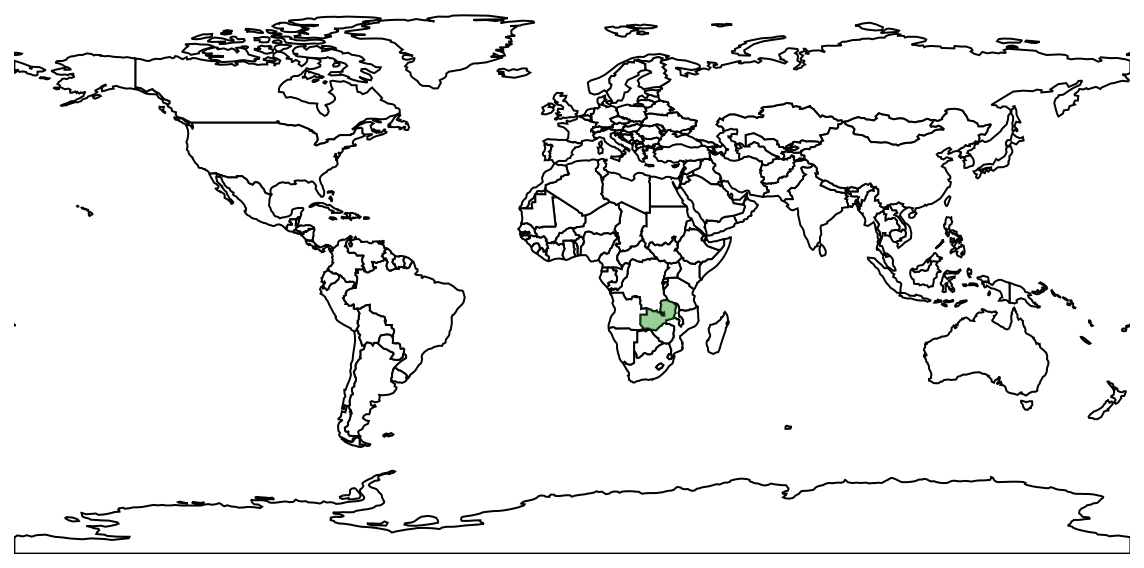

In [106]:
ax = gplt.polyplot(world,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    world.loc[world.name == 'Zambia'], hue='name', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, cmap=mycols_cmap, extent=world.total_bounds.round()
) ;


In [107]:
# africa = world[world.continent == 'Africa']
africa = world[(world.continent == 'Africa') | (world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]
africa_midres = world_midres[(world_midres.continent == 'Africa') | (world_midres.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
                           'Israel', 'Jordan', 'Qatar', 'Kuwait']))]

In [108]:
africa.name.unique().size, africa_midres.name.unique().size

(59, 62)

## Clean map

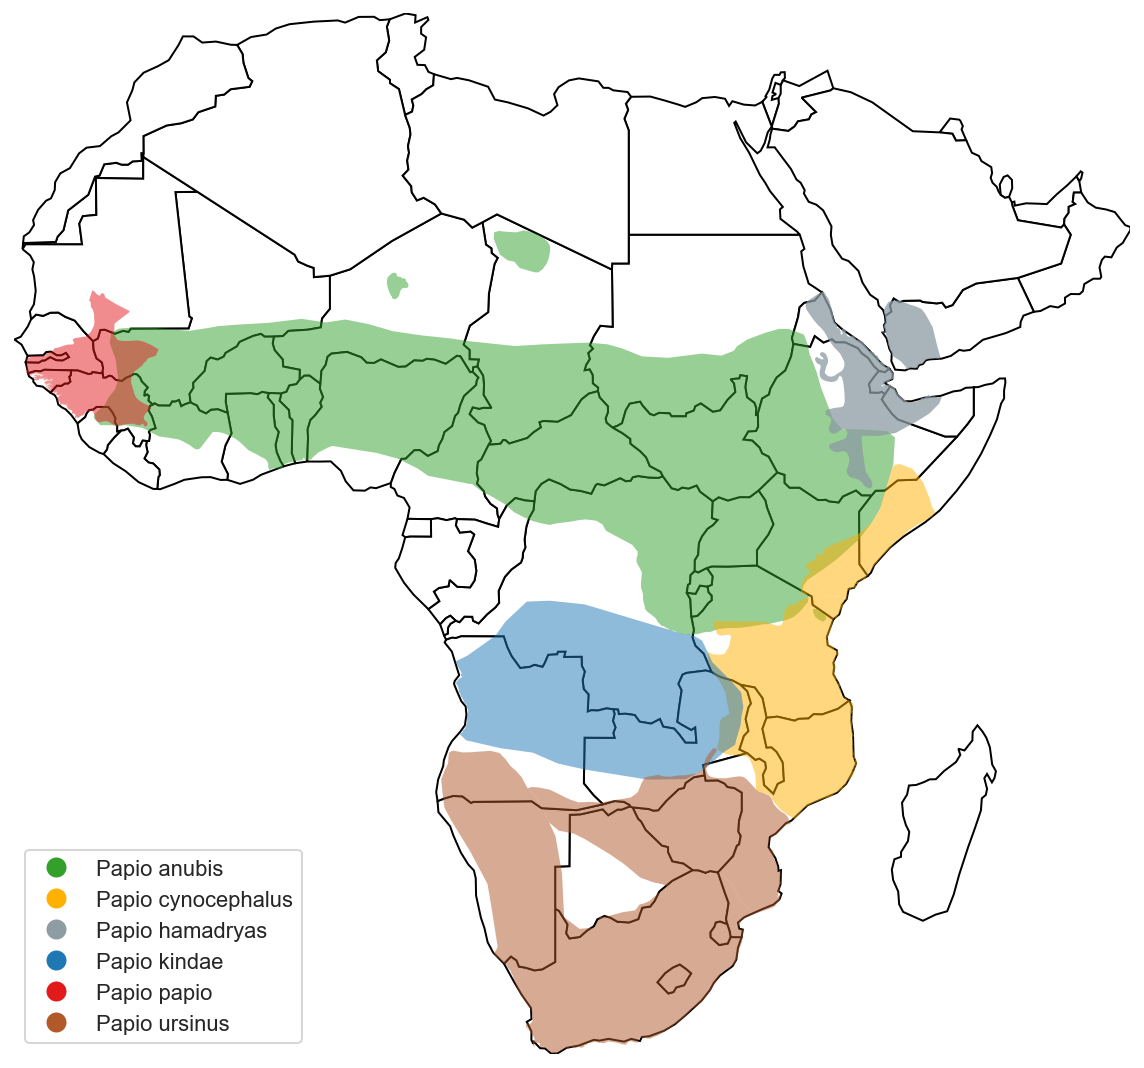

In [109]:
# world.loc[world.name.isin(['Saudi Arabia', 'Yemen', 'Oman', 'United Arab Emirates',
#                            'Israel', 'Jordan', 'Qatar', 'Kuwait'])]

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
plt.savefig('../figures/ranges.pdf')

## GeoDataFrame

In [110]:
gdf = gpd.GeoDataFrame(meta_data, geometry=gpd.points_from_xy(meta_data.longitude, meta_data.latitude)).loc[lambda df: df.Species != 'gelada']
gdf.loc[gdf.Species == 'ursinus (grayfoot)', 'Species'] = 'ursinus'
gdf.head()

,Unnamed: 0,PGDP_ID,Provider_ID,Provider,Genus,Species,Origin,Sex,address,longitude,latitude,geometry
1,1,PD_0199,09SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.76917,-1.960026,POINT (34.76917 -1.96003)
2,2,PD_0200,11SNF1101115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.76917,-1.960026,POINT (34.76917 -1.96003)
3,3,PD_0201,19SNM1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",M,"Serengeti, Mara, Lake Zone, Tanzania",34.76917,-1.960026,POINT (34.76917 -1.96003)
4,4,PD_0202,20SNF1131115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.76917,-1.960026,POINT (34.76917 -1.96003)
5,5,PD_0203,21SNF1151115,Knauf/Chuma/Roos,Papio,anubis,"Serengeti, Tanzania",F,"Serengeti, Mara, Lake Zone, Tanzania",34.76917,-1.960026,POINT (34.76917 -1.96003)


## Sampling locations for each species

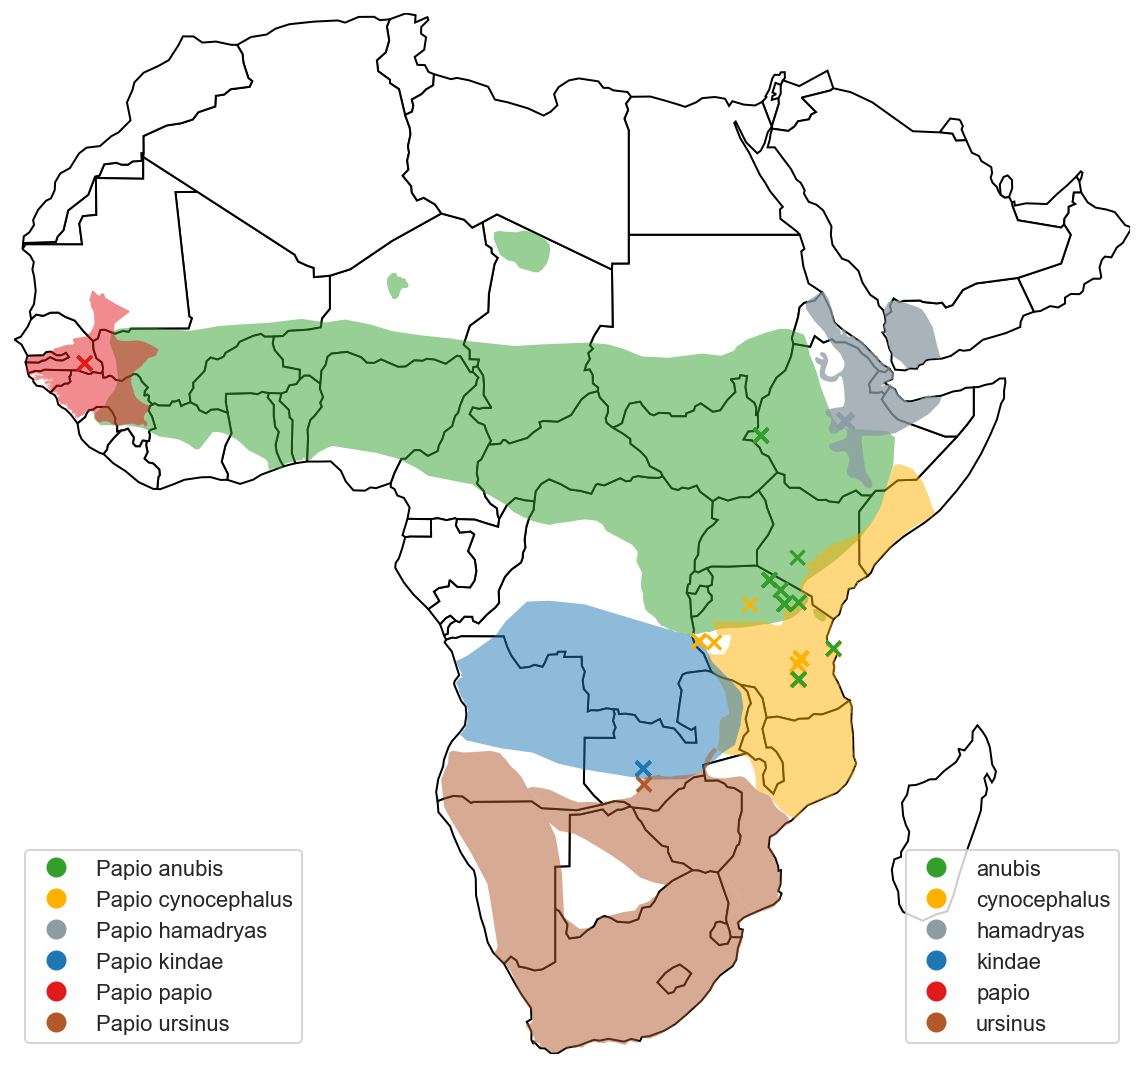

In [111]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

# overwrites first legend
gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='x',
               zorder=10, s=7, hue='Species', legend=True, cmap=mycols_cmap, 
              legend_kwargs=dict(loc='lower right'));

# manually add the first legend back
ax.add_artist(leg1); 

## Plot with each sample as male or female

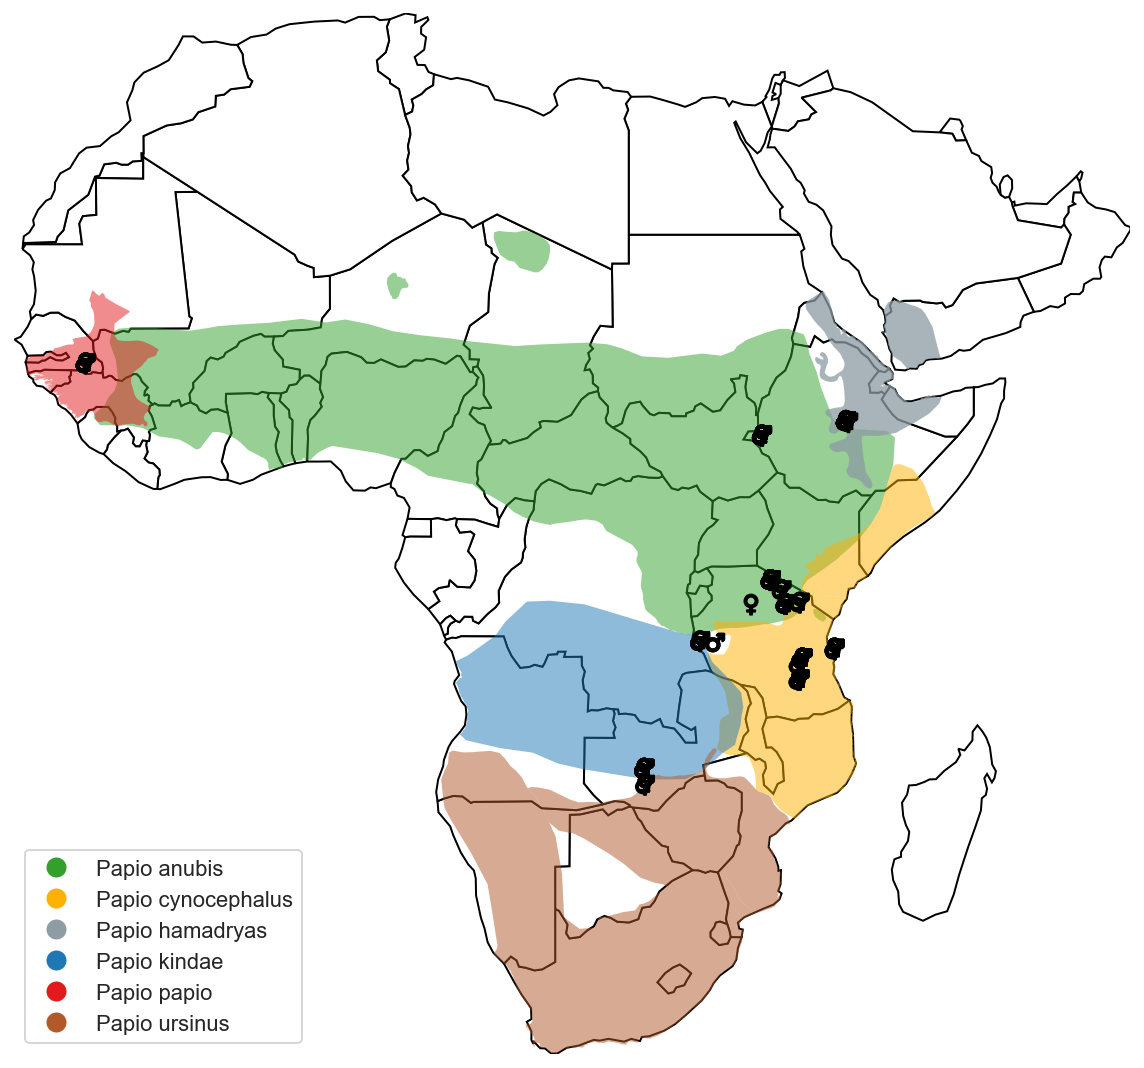

In [112]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf.loc[gdf.Sex=='F'], ax=ax, extent=africa.total_bounds, marker="$\u2640$",
               zorder=10, s=10, color='black');
gplt.pointplot(gdf.loc[gdf.Sex=='M'], ax=ax, extent=africa.total_bounds, marker="$\u2642$",
               zorder=10, s=10, color='black');

In [113]:
gdf['dummy'] = np.random.random(gdf.index.size)

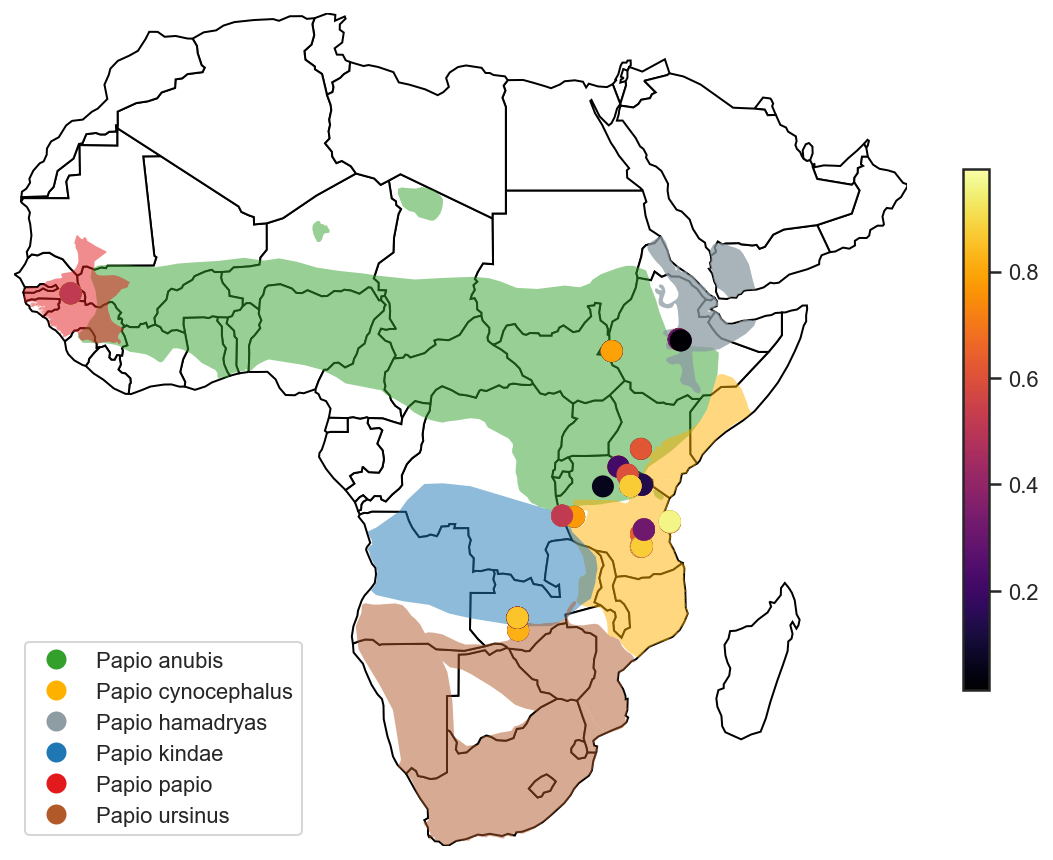

In [114]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;

gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, marker='o', #scheme=None,
               zorder=10, s=10, hue='dummy', legend=True, 
               legend_kwargs=dict(shrink=0.4), 
               cmap='inferno');

## Numbers of samples at each location

In [115]:
geo_loc = (gdf[['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

,Origin,Species,geometry,nr_samples
0,"Aberdare, Kenya",anubis,POINT (36.71245 -0.41025),2
1,"Arusha, Tanzania",anubis,POINT (36.80042 -3.52387),4
2,"Awash, Ethiopia",hamadryas,POINT (40.16767 8.99250),2
3,"Chunga, Zambia",kindae,POINT (26.00521 -15.05356),28
4,"Dendro Park, Zambia",ursinus,POINT (26.06255 -16.14544),4
5,"Filoha, Ethiopia",hamadryas,POINT (40.00001 9.08358),24
6,"Gog Woreda, Gambella region, Ethiopia",anubis,POINT (34.17906 8.07397),25
7,"Gombe, Tanzania",anubis,POINT (36.79745 -8.85799),17
8,"Issa Valley, Tanzania",cynocephalus,POINT (33.41658 -3.66533),1
9,"Katavi, Tanzania",cynocephalus,POINT (30.92783 -6.30155),2


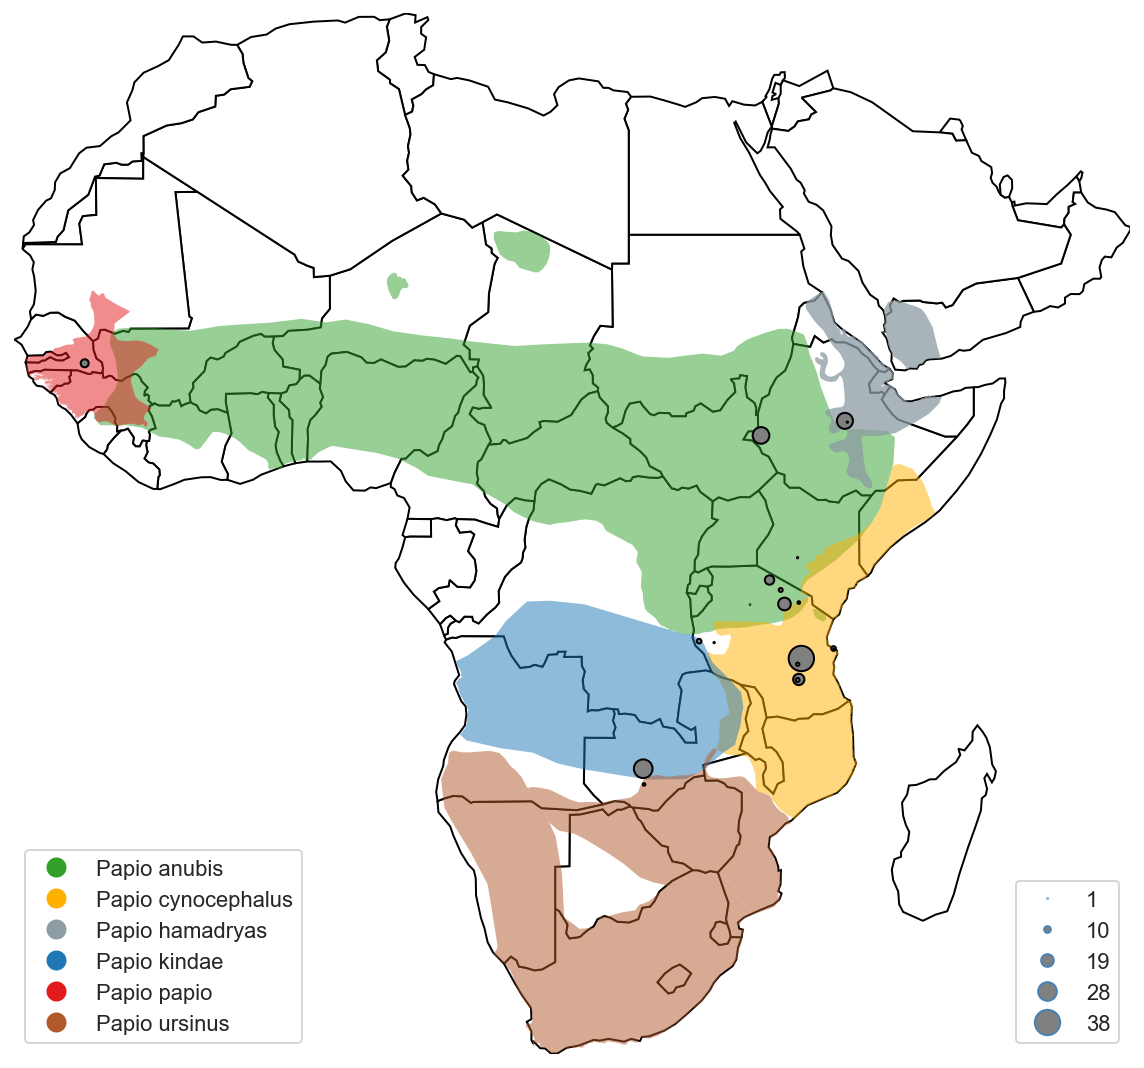

In [116]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

## Numbers of males sampled at each location

In [117]:
geo_loc = (gdf.loc[gdf.Sex == 'M', ['Origin', 'Species', 'Sex', 'geometry']]
           .dissolve(by=["Origin", 'Species'], 
                     aggfunc='count').rename(columns={'Sex': 'nr_samples'})
           .reset_index()
          )
geo_loc

,Origin,Species,geometry,nr_samples
0,"Arusha, Tanzania",anubis,POINT (36.80042 -3.52387),2
1,"Awash, Ethiopia",hamadryas,POINT (40.16767 8.99250),1
2,"Chunga, Zambia",kindae,POINT (26.00521 -15.05356),19
3,"Dendro Park, Zambia",ursinus,POINT (26.06255 -16.14544),1
4,"Filoha, Ethiopia",hamadryas,POINT (40.00001 9.08358),19
5,"Gog Woreda, Gambella region, Ethiopia",anubis,POINT (34.17906 8.07397),17
6,"Gombe, Tanzania",anubis,POINT (36.79745 -8.85799),7
7,"Katavi, Tanzania",cynocephalus,POINT (30.92783 -6.30155),2
8,"Lake Manyara, Tanzania",anubis,POINT (35.80649 -3.62221),4
9,"Mahale, Tanzania",cynocephalus,POINT (29.88343 -6.20329),5


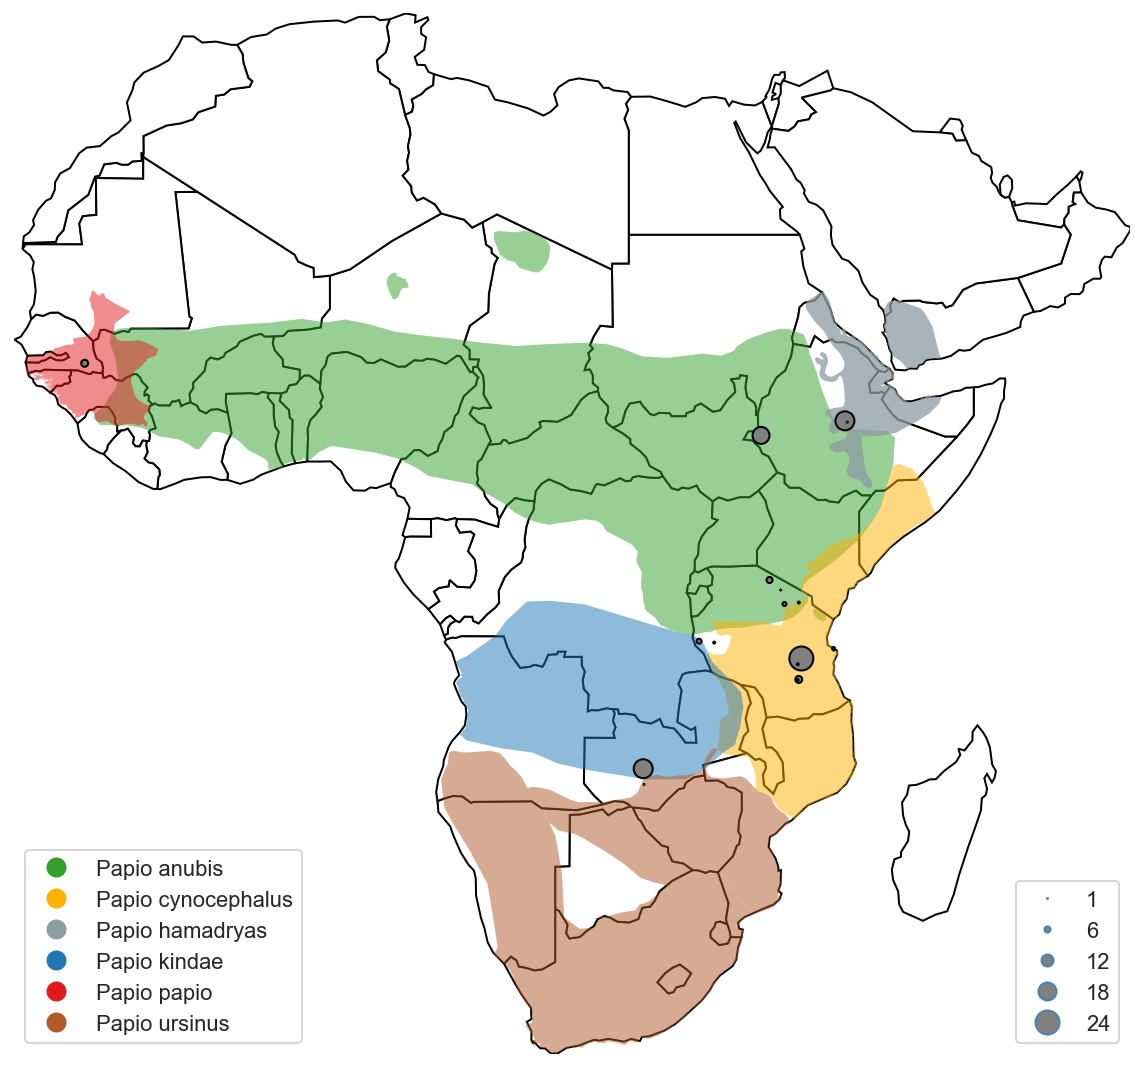

In [118]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 2
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right'),
              );

# manually add the first legend back
ax.add_artist(leg1); 

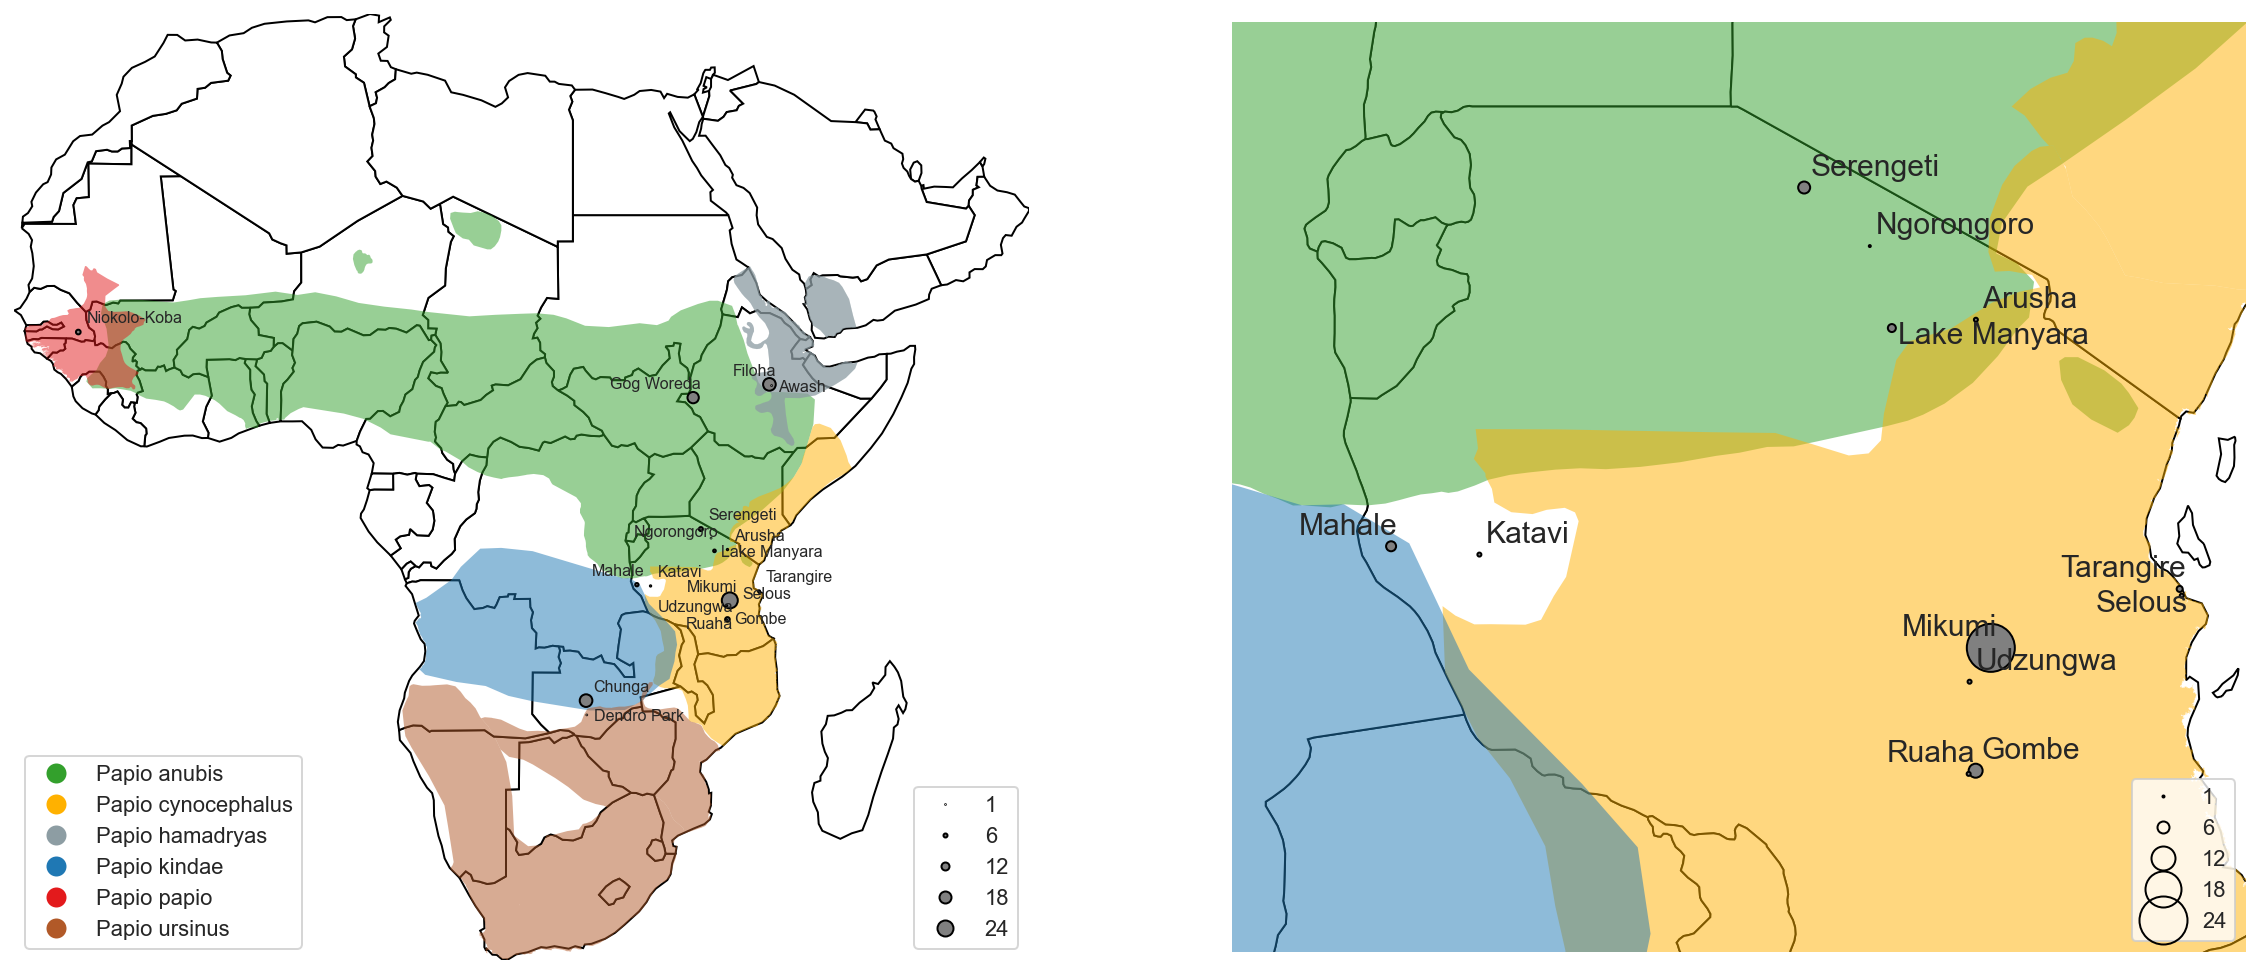

In [119]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(20, 12))


ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', ax=ax)
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    texts.append(ax.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder=10, size=8))
adjust_text(texts)
    
# manually add the first legend back
ax.add_artist(leg1); 


ax = gplt.polyplot(africa_midres,
    facecolor='white', edgecolor='black', ax=ax2)
ax.set_facecolor('white')

extent = (28, -11, 40, 0)

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax2, 
    extent=extent,
    cmap=mycols_cmap, legend=True,
) ;
# get legend
leg1 = ax2.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax2, extent=extent,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black', markerfacecolor='none'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    if extent[0] < x < extent[2] and extent[1] < y < extent[3]:
        texts.append(ax2.annotate(label, xy=(x, y), xytext=(3, 3), textcoords="offset points", zorder=10, size=15))
adjust_text(texts)        

plt.savefig('../figures/baboon_samples.pdf')

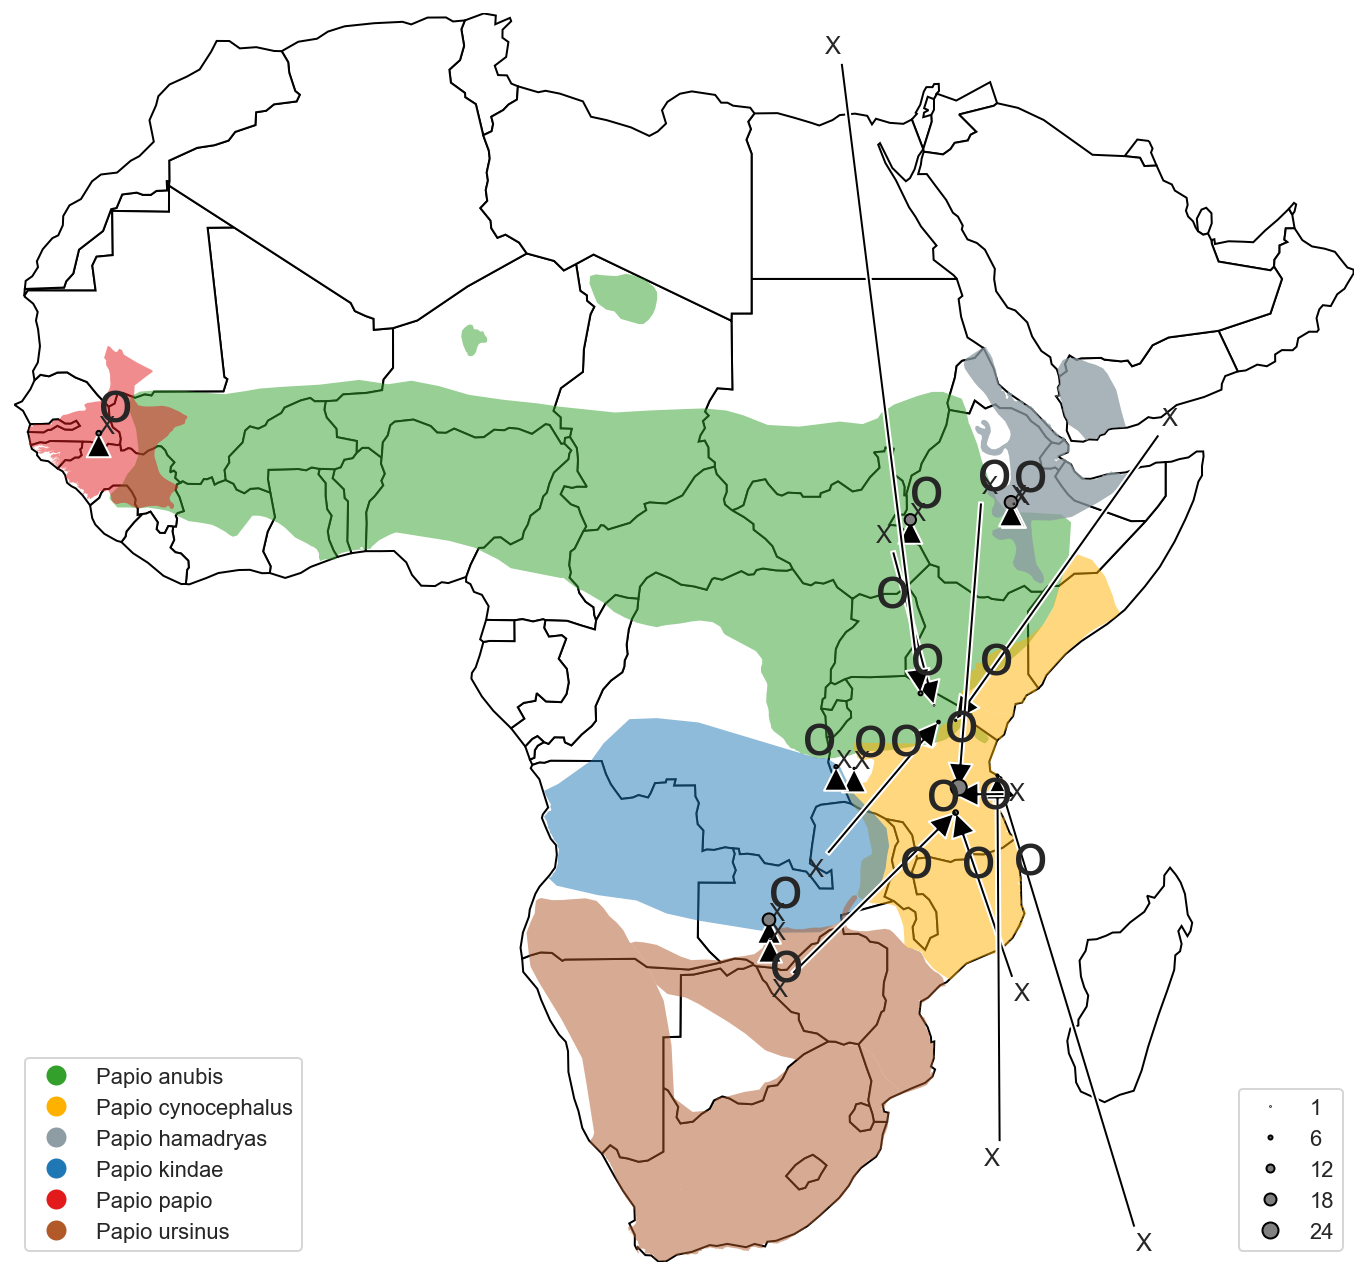

In [120]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))


ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', ax=ax)
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;
# get legend
leg1 = ax.axes.get_legend()

def scale_func(minval, maxval):
    def scalar(val):
        return val / 3
    return scalar

# overwrites first legend
gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
               zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
               color='grey',
               #fillstyle='none', 
#                scatter_kws = {'fillstyle':'none'},
               edgecolors='black',
               legend_kwargs=dict(loc='lower right', markeredgecolor='black'),
              );

texts = []
for x, y, label in zip(geo_loc.geometry.x, geo_loc.geometry.y, [x.split(',')[0] for x in geo_loc.Origin]):
    texts.append(ax.annotate("o", xy=(x, y), xytext=(0, 0), 
                             textcoords="offset points", 
                             zorder=10, size=30))
adjust_text(texts)
    
# manually add the first legend back
ax.add_artist(leg1); 


pos = list(zip(geo_loc.geometry.x, geo_loc.geometry.y))
offsets = [x.get_position() for x in texts]
for ((x, y), (a, b)) in zip(pos, offsets):
    ax.annotate("X", xy=(x, y), xytext=(x+a, y+b), 
           arrowprops=dict(facecolor='black', width=2))

In [121]:
texts

[Text(11.932380335888432, 17.068331700062135, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(3.373947534240223, -10.850422511830194, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(-7.558900463062019, -8.899845154554267, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(1.3129894899915808, 17.029760778450036, 'o'),
 Text(-3.3622599960875914, 9.444904171653246, 'o'),
 Text(0.0, 0.0, 'o'),
 Text(-10.528825028784343, -10.569236177240835, 'o'),
 Text(7.985516738194896, -27.36664778140692, 'o'),
 Text(-5.51834723440973, 37.001337884598954, 'o'),
 Text(-0.7932467724516914, -22.504227452968994, 'o'),
 Text(3.1567453964802463, -0.35395545676312423, 'o'),
 Text(12.492101186622268, 14.133608566358951, 'o'),
 Text(12.492101186622268, 14.133608566358951, 'o')]

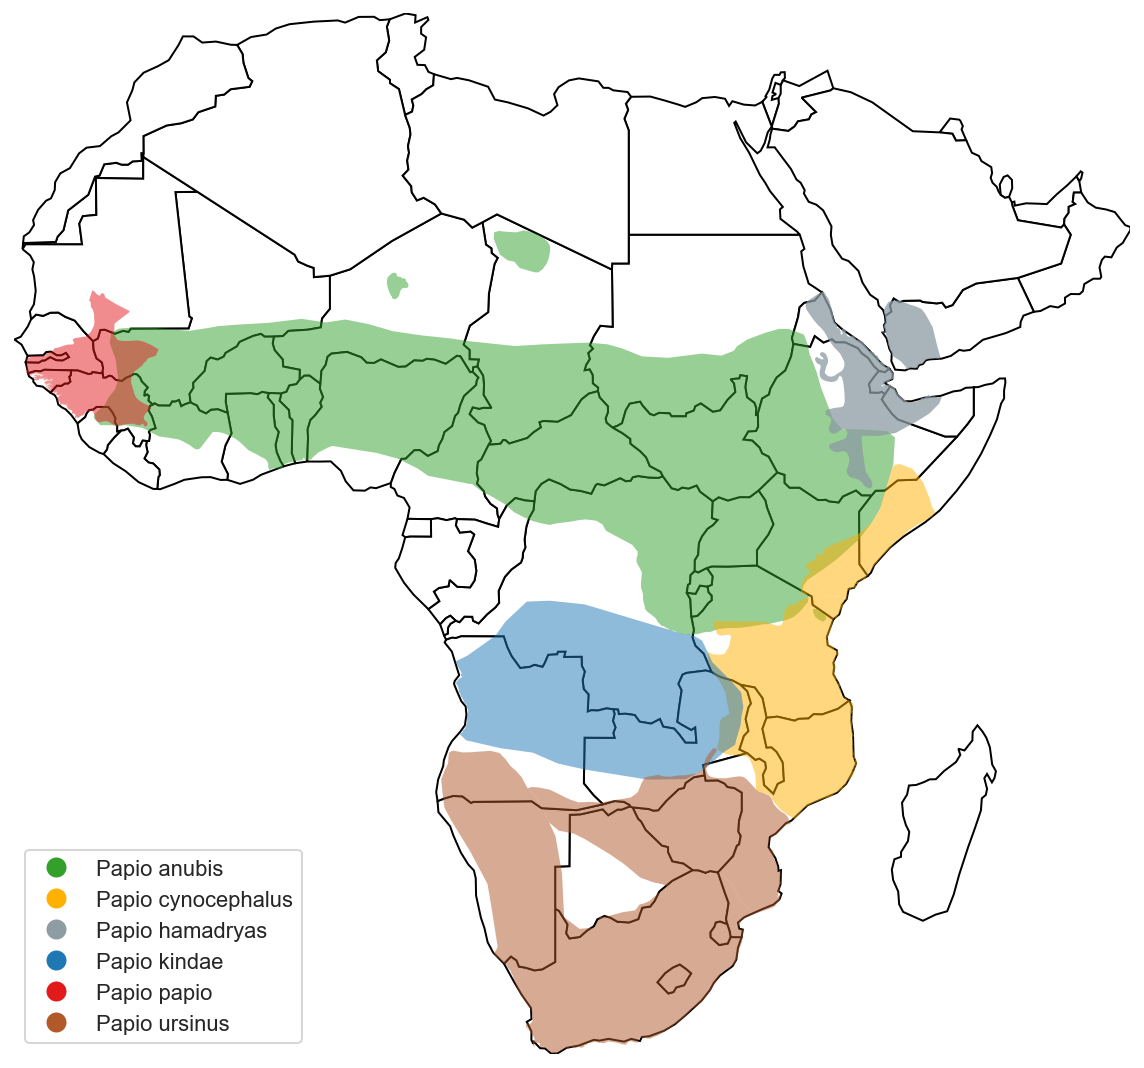

In [122]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='black', figsize=(10, 12))
ax.set_facecolor('white')

gplt.choropleth(
    ranges_gdf, hue='BINOMIAL', linewidth=0, scheme=None, alpha=0.5, 
    ax=ax, extent=africa.total_bounds, cmap=mycols_cmap, legend=True
) ;


import cartopy.crs as ccrs


# # overwrites first legend
# gplt.pointplot(geo_loc, ax=ax, extent=africa.total_bounds,
#                zorder=10, scale='nr_samples', scale_func=scale_func, legend=True, 
#                color='grey',
#                #fillstyle='none', 
# #                scatter_kws = {'fillstyle':'none'},
#                edgecolors='black',
#                legend_kwargs=dict(loc='lower right'),
#               );

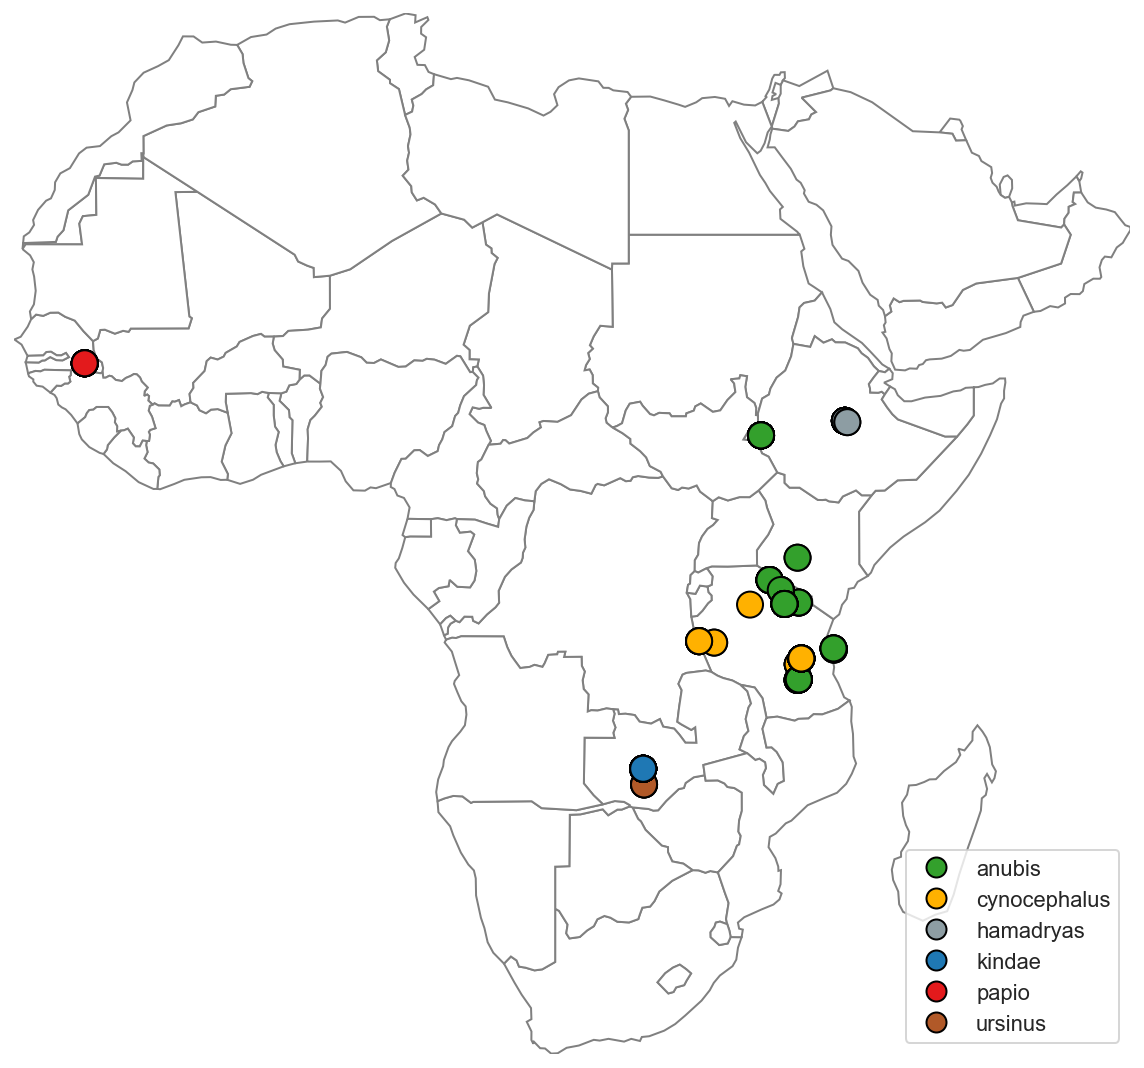

In [123]:
ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='grey', figsize=(10, 12))
ax.set_facecolor('white')

# overwrites first legend
ax = gplt.pointplot(gdf, ax=ax, extent=africa.total_bounds, 
                marker='o', linewidth=1, edgecolor='black',
#               marker='x',
               zorder=10, s=13, hue='Species', legend=True, cmap=mycols_cmap, 
              legend_kwargs=dict(loc='lower right'));


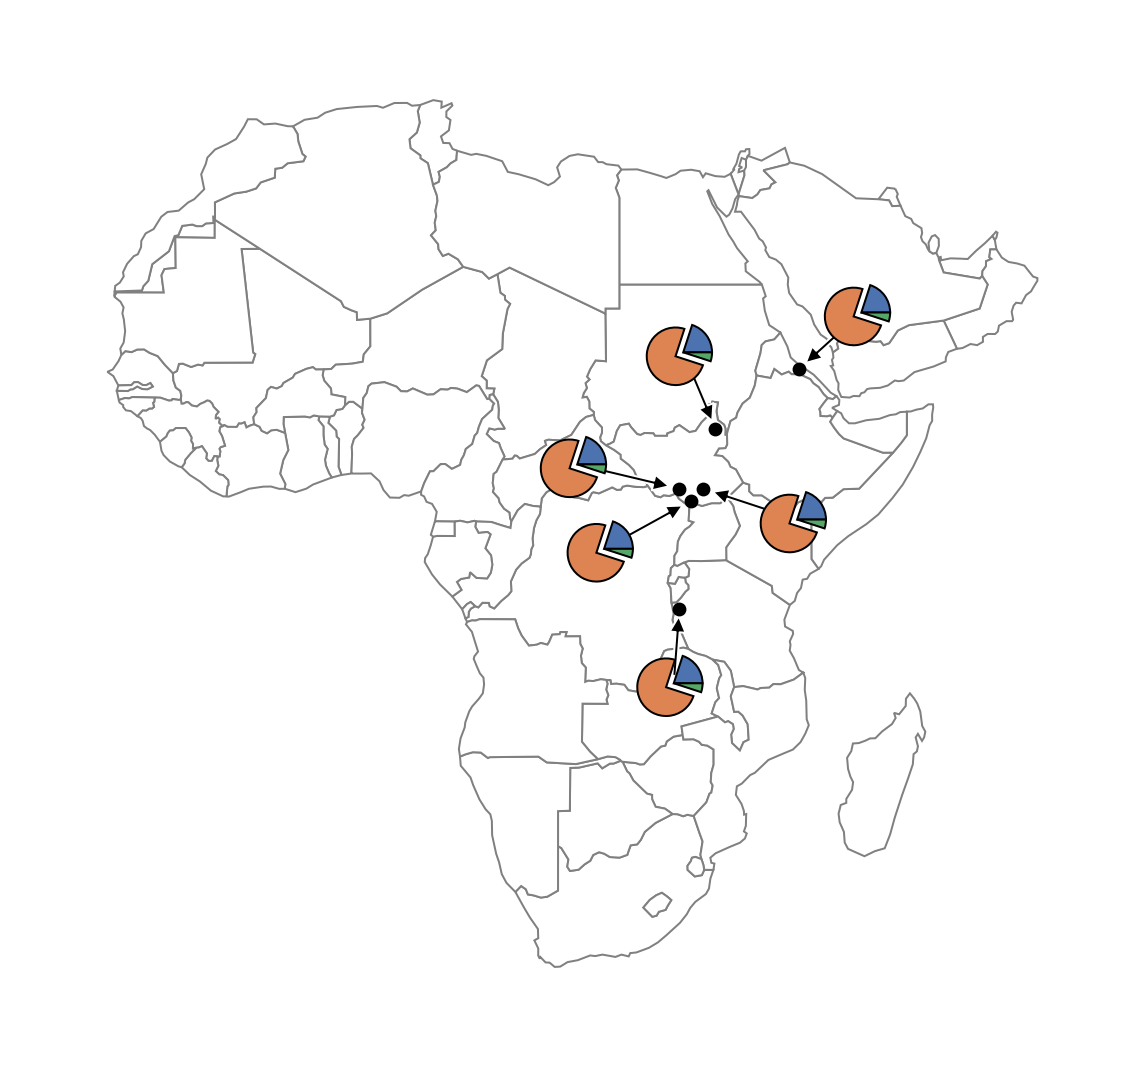

In [163]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import mpl_toolkits.axes_grid1.axes_size as Size


def plot_pie_inset(data,ilon,ilat,ax,width,lon_offset=0, lat_offset=0):
    
    if lon_offset or lat_offset:
        ax.scatter(ilon, ilat, color='black', zorder=50, s=35)

    ax_sub= inset_axes(ax, width=width, height=width, loc=10, 
                       bbox_to_anchor=(ilon+lon_offset, ilat+lat_offset),
                       bbox_transform=ax.transData, 
                       borderpad=0)

    if lon_offset or lat_offset:
#        ax.plot([ilon, ilon+lon_offset], [ilat, ilat+lat_offset], color='black', zorder=50, linestyle='dashed')
#         ax.arrow(ilon, ilat, lon_offset, lat_offset, color='black', zorder=100, linestyle='dashed', 
#                  length_includes_head=False, 
#                  head_starts_at_zero=True, 
#                  head_width=1)
        ax.annotate("", xy=(ilon,ilat), xytext=(ilon+lon_offset,ilat+lat_offset), 
                    arrowprops=dict(facecolor='black', width=2, headwidth=8, headlength=8, shrink=.1))
    
    wedges,texts= ax_sub.pie(data, 
                             explode=(0, 0.3, 0), 
                             startangle=0,
                             wedgeprops={"edgecolor":"black", 'linewidth': 1})

    ax_sub.set_aspect("equal")

    
def get_pie_posistions(lon_lat_coord, ax, k=None, seed=None):
    
    xy_coords = [ax.transData.transform(coord) for coord in lon_lat_coord]
    
    G = nx.Graph()
    nodes = range(len(xy_coords*2))
    G.add_nodes_from(nodes)
    G.add_edges_from(zip(nodes[0:-1:2], nodes[1::2]))

    pos = dict(zip(nodes[0:-1:2], xy_coords))
    
    xy_layout = nx.spring_layout(G, fixed=nodes[0:-1:2], pos=pos, seed=seed, k=k)

    pie_xy_coord = [tuple(coord) for (n, coord) in sorted(xy_layout.items())][1::2]

    pie_lon_lat_coord = [tuple(ax.transData.inverted().transform(coord)) for coord in pie_xy_coord]
    return pie_lon_lat_coord
    
    

ax = gplt.polyplot(africa,
    facecolor='white', edgecolor='gray', figsize=(10, 12))    
    
lon_lat_coords = [(33,10), (40,15), (30,5), (31,4),(32,5), (30,-5)]            
                  
pie_lon_lat_coords = get_pie_posistions(lon_lat_coords, ax, k=30, seed=2)
    
for point, pie in zip(lon_lat_coords, pie_lon_lat_coords):
    point_x, point_y = point
    pie_x, pie_y = pie
    plot_pie_inset([0.2, 0.75, 0.05],point_x,point_y,ax,0.5, 
                   lon_offset=pie_x-point_x, lat_offset=pie_y-point_y)

    

